In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        file_names.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt

def see_image(x):
    z=plt.imread(x)
    plt.imshow(z)
    print(z.shape)

(4000, 6000, 3)


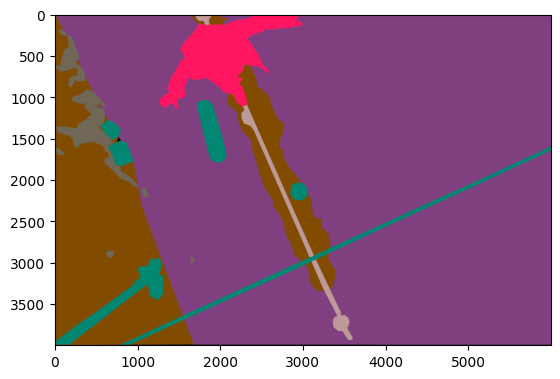

In [3]:
see_image("/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/304.png")

(4000, 6000)


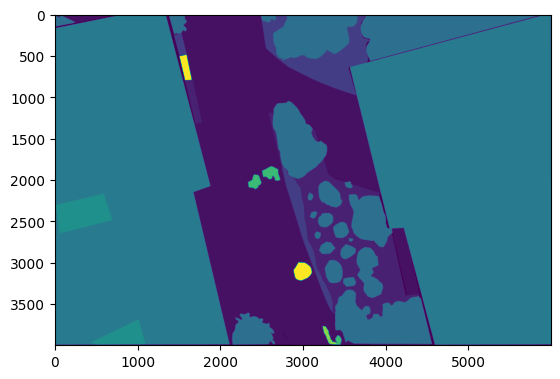

In [4]:
see_image("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/077.png")

(4000, 6000, 3)


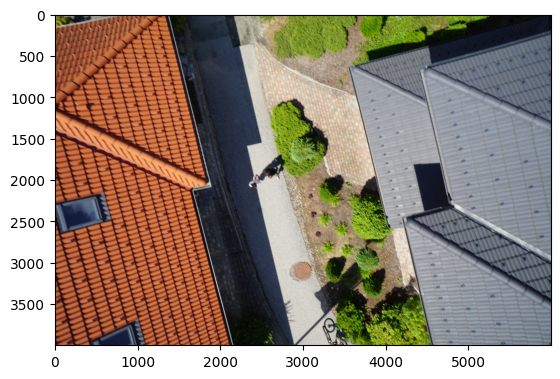

In [6]:
see_image("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/077.jpg")

In [7]:
file_names.sort()

In [ ]:
#file_names

In [29]:
k=file_names.index('/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/598.png')

color_images_mask=[]
for i in range(0,k+1):
    color_images_mask.append(file_names[i])


In [30]:
label_images_semantic=[]
z=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png")

print(z)

z1=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/598.png")
print(z1)

for i in range(z,z1+1):
    label_images_semantic.append(file_names[i])
    

401
800


In [31]:
original_images=[]

z2=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg")
z3=file_names.index("/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/598.jpg")
print(z2,z3)


for i in range(z2,z3+1):
    original_images.append(file_names[i])

801 1200


In [63]:
#now we have the images 
#now lets differentiate them into the train and the test set 
train_original_images=[]
test_original_images=[]

train_label_images_semantic=[]
test_label_images_semantic=[]

n=len(original_images)
print(n*0.85)

340.0


The image is of the size 4000x6000x3  which is of a big size , so here we try to reduce the size to 256,256,3


In [62]:
from PIL import Image

def resize_image(image_path):
    img = Image.open(image_path)
    resized_img = img.resize((256, 256))
    return resized_img



In [64]:
# original_images and label_images_semantic are lists of image paths

for i in range(len(original_images)):
    if i < 340:
        a = resize_image(original_images[i])
        b = resize_image(label_images_semantic[i])
        train_original_images.append(a)
        train_label_images_semantic.append(b)
    else:
        c = resize_image(original_images[i])
        d = resize_image(label_images_semantic[i])
        test_original_images.append(c)
        test_label_images_semantic.append(d)



In [ ]:
'''
import tensorflow as tf

def resize_images(images, target_size):
    resized_images = tf.image.resize(images, target_size)
    return resized_images

target_size = (256, 256)  # Example target size

train_original_images_resized = resize_images(train_original_images, target_size)
train_label_images_semantic_resized = resize_images(train_label_images_semantic, target_size)
'''

Now we have the training and the testing dataset , we now create and define our model 


In [66]:
#first we import the needed dependencies 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense,Input,Conv2D,GlobalAveragePooling2D,MaxPool2D,Add,BatchNormalization,Reshape,UpSampling2D,Concatenate
from keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.utils import plot_model
from IPython.display import display, Image as DisplayImage

Here the input of the psp net model would be a 4000x6000x3  we will give this image to our model 
and we will subsequently downsample the model  using  the maxpool2d 

In [68]:
class PSP_net():
    def __init__(self):
        self.input_size=(256,256,3)
        self.padding='same'
        self.activation='relu'
        self.model=None
    
    def build_model(self):
        input1=Input(self.input_size)
        conv_1=Conv2D(5,3,padding=self.padding,activation=self.activation)(input1)
        batch_normalization1=BatchNormalization()(conv_1)
        conv_2=Conv2D(5,3,padding=self.padding,activation=self.activation)(batch_normalization1)
        conv_3=Conv2D(8,5,padding=self.padding,activation=self.activation)(conv_2)
        batch_normalization=BatchNormalization()(conv_3)
        conv_4=Conv2D(3,3,padding=self.padding,activation=self.activation)(batch_normalization)
        #now here we integrate the pyramid pooling layer
        
        conv_5=Conv2D(1,1,activation=self.activation,padding=self.padding)(conv_4) #this will give the size as 1x1
        global_average_pooling=GlobalAveragePooling2D()(conv_5)
        
        # Reshape to 4D tensor
        global_average_pooling_reshaped = Reshape((1, 1, 1))(global_average_pooling)
        
        
        #here we write the second scale 
        
        conv_6=Conv2D(1,1,padding=self.padding,activation=self.activation)(conv_4)
        maxpool_3=MaxPool2D((128,128))(conv_6) #this will give the size as 2x2
        
        #the third part with size 4x4
        
        conv_7=Conv2D(1,1,padding=self.padding,activation=self.activation)(conv_4)
        maxpool_4=MaxPool2D((64,64))(conv_7)
        
        #now after getting the 1x1 ,2x2 and the 4x4 model 
        #we would upsample the downsampled feature and try to bring it to the same dimension 
        upsampling_1=UpSampling2D((256,256),interpolation='nearest')(global_average_pooling_reshaped)
        upsampling_2=UpSampling2D((128,128),interpolation='bilinear')(maxpool_3)
        upsampling_3=UpSampling2D((64,64),interpolation='bilinear')(maxpool_4)
        
        #now after getting the upsampled  values , we would add them 
        
        concatenate_layer=Concatenate()([upsampling_1,upsampling_2,upsampling_3])
        
        #and then add the conv layer output feature vector to the following concatenate_layer 
        add_layer=Add()([concatenate_layer,conv_4])
        
        conv_8=Conv2D(1,1,padding=self.padding,activation=self.activation)(add_layer)
        
        
        model=Model(inputs=input1,outputs=conv_8)
        
        self.model=model
        return self.model #this returns the model 
        
        
    def summary_model(self):
        self.model.summary() 
        
        
    def plot_model(self):
        plot_model(self.model, show_shapes=True, show_layer_names=True, to_file='model.png')
        display(DisplayImage('model.png'))

        
    def compile_model(self):
        self.model.compile(loss=CategoricalCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'],run_eagerly=True)
        
        
        
        
        
        
    
    

In [69]:
psp_model=PSP_net()

k=psp_model.build_model()

In [70]:
psp_model.summary_model()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │        140 │ input_layer_4[0]… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         20 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │        230 │ batch_normalizat… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │      1,008 │ conv2d_33[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 256, 256,  │        219 │ batch_normalizat… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 256, 256,  │          4 │ conv2d_35[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ conv2d_36[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 256, 256,  │          4 │ conv2d_35[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │          4 │ conv2d_35[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 1)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 2, 2, 1)   │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 4, 4, 1)   │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 256, 256,  │          0 │ reshape_4[0][0]   │
│ (UpSampling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_14    │ (None, 256, 256,  │          0 │ max_pooling2d_10… │
│ (UpSampling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (None, 256, 256,  │          0 │ max_pooling2d_11… │
│ (UpSampling2D)      │ 1)                │            │                 

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,639 (6.40 KB)

 Non-trainable params: 26 (104.00 B)

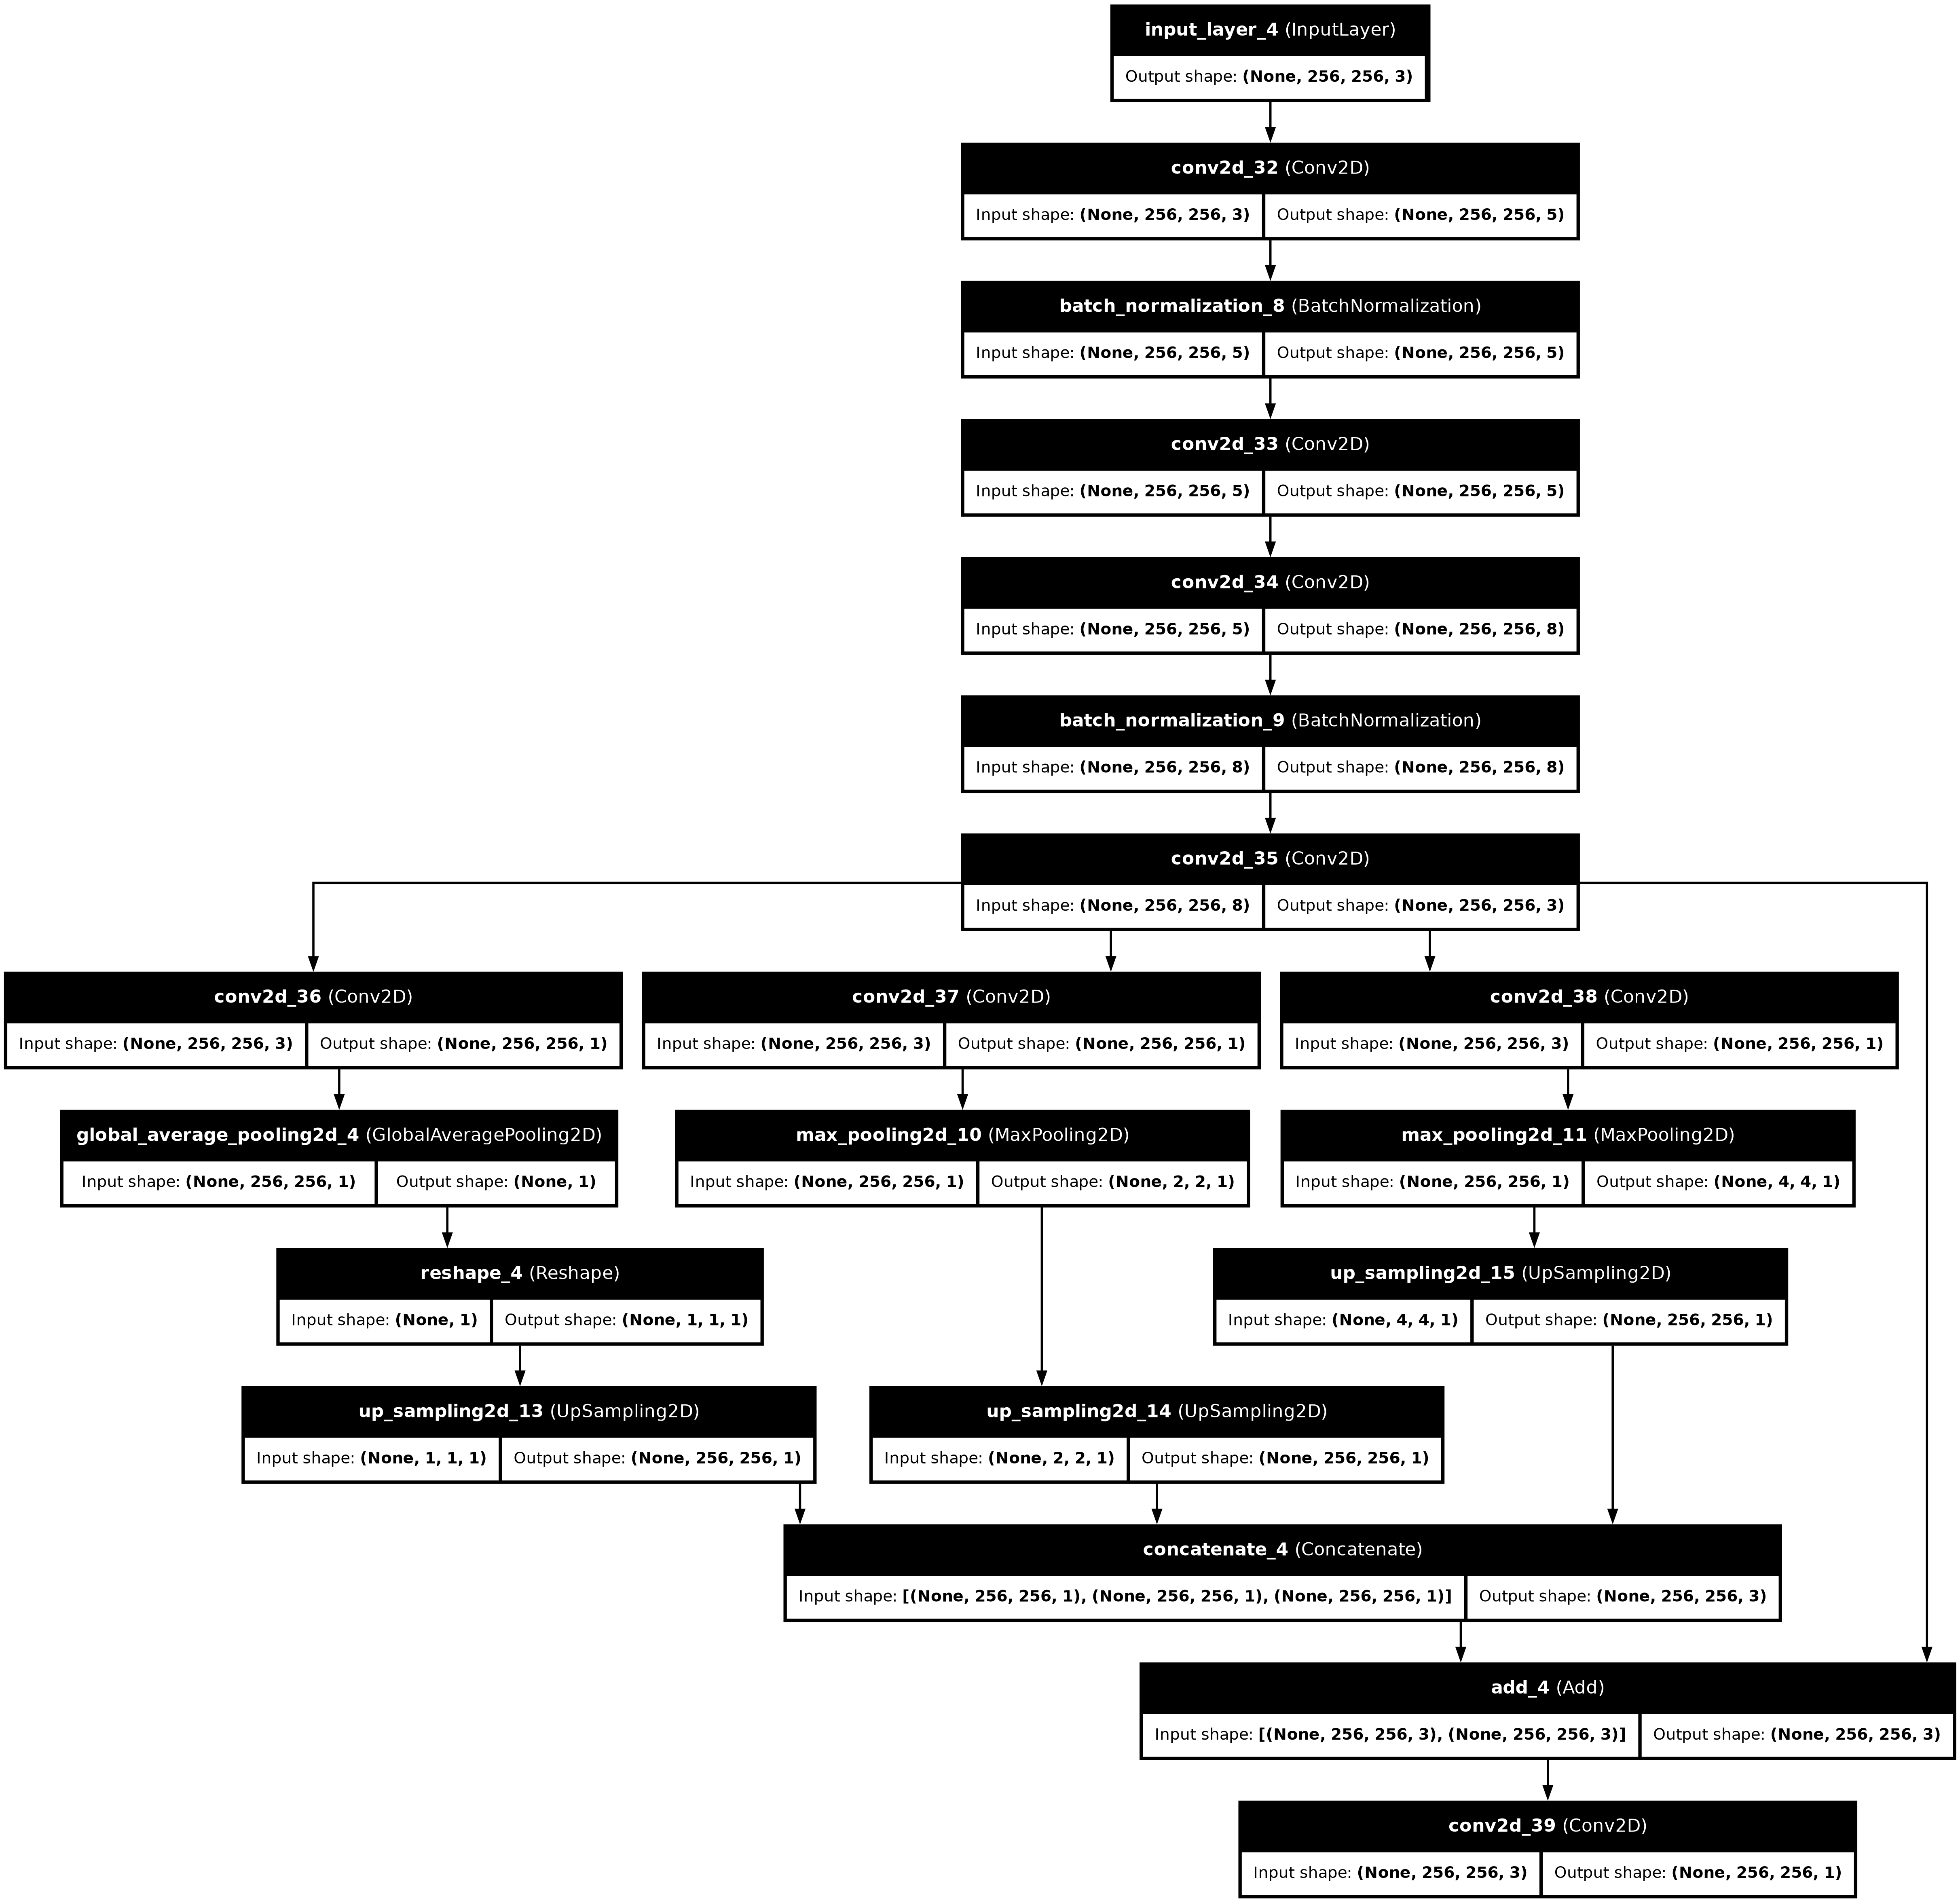

In [72]:

#now after getting the model 
#lets plot the model
psp_model.plot_model()



In [73]:
psp_model.compile_model()

In [74]:
import numpy as np

train_original_images=np.asarray(train_original_images)
train_label_images_semantic=np.asarray(train_label_images_semantic)

In [77]:
k.fit(train_original_images,train_label_images_semantic,verbose=1,batch_size=2,epochs=10)
        

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 379ms/step - accuracy: 0.3688 - loss: 7029.1997
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 380ms/step - accuracy: 0.3639 - loss: 7074.4297
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 379ms/step - accuracy: 0.3459 - loss: 7310.3003
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - accuracy: 0.3779 - loss: 6956.8530
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 375ms/step - accuracy: 0.3552 - loss: 7184.7065
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 381ms/step - accuracy: 0.3866 - loss: 7211.8286
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.3461 - loss: 7222.7993
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.3613 - loss: 7040.4912
Epoch 9/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.3404 - loss: 7251.3472
Epoch 10/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.3405 - loss: 7202.0776
